In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import torch.optim  as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy
import shap

from models.CNN_EEG import CNNEEG_32, restore_parameters, train_CNNEEG, evaluation_eegcnn
from utils import MakeDataset, generation_cnn_data, generation_cnn_noisedata, generation_cnn_con_data

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
eeg_col = ['EEG.Cz', 'EEG.Fz', 'EEG.Fp1',  'EEG.F7', 'EEG.F3', 'EEG.FC1', 'EEG.C3','EEG.FC5',
           'EEG.FT9', 'EEG.T7','EEG.CP5',  'EEG.CP1', 'EEG.P3', 'EEG.P7', 'EEG.PO9', 'EEG.O1',
           'EEG.Pz', 'EEG.Oz', 'EEG.O2', 'EEG.PO10', 'EEG.P8', 'EEG.P4', 'EEG.CP2', 'EEG.CP6',
            'EEG.T8', 'EEG.FT10', 'EEG.FC6', 'EEG.C4', 'EEG.FC2', 'EEG.F4', 'EEG.F8', 'EEG.Fp2']

In [3]:
path = './{}/base/{}.csv'
task = ['10','20','1back','3back']

# CYY base dataset train

In [4]:
cyj_cnn_eeg_input, cyj_cnn_output = generation_cnn_data(path, 'sbs', task, device)

10
20
1back
3back


In [5]:
print(cyj_cnn_eeg_input.size())
print(cyj_cnn_output.size())

torch.Size([2048, 32, 120])
torch.Size([2048])


In [6]:
dataset = MakeDataset(cyj_cnn_eeg_input, cyj_cnn_output)
train_dataset, test_dataset = random_split(dataset, [1536,512])
trainloader = DataLoader(train_dataset, 
                         batch_size=256, 
                         shuffle=True)

testloader = DataLoader(test_dataset,
                        batch_size = 256,
                        shuffle=True)


In [9]:
model = CNNEEG_32(32)
his = train_CNNEEG(model, trainloader, 1000, 0.001, device= device)

Epoch 1 / 1000: Loss = 1.098
Epoch 2 / 1000: Loss = 1.054
Epoch 3 / 1000: Loss = 1.018
Epoch 4 / 1000: Loss = 0.994
Epoch 5 / 1000: Loss = 0.979
Epoch 6 / 1000: Loss = 0.967
Epoch 7 / 1000: Loss = 0.958
Epoch 8 / 1000: Loss = 0.955
Epoch 9 / 1000: Loss = 0.949
Epoch 10 / 1000: Loss = 0.947
Epoch 11 / 1000: Loss = 0.951
Epoch 12 / 1000: Loss = 0.938
Epoch 13 / 1000: Loss = 0.935
Epoch 14 / 1000: Loss = 0.930
Epoch 15 / 1000: Loss = 0.930
Epoch 16 / 1000: Loss = 0.924
Epoch 17 / 1000: Loss = 0.917
Epoch 18 / 1000: Loss = 0.911
Epoch 19 / 1000: Loss = 0.912
Epoch 20 / 1000: Loss = 0.907
Epoch 21 / 1000: Loss = 0.907
Epoch 22 / 1000: Loss = 0.905
Epoch 23 / 1000: Loss = 0.908
Epoch 24 / 1000: Loss = 0.898
Epoch 25 / 1000: Loss = 0.895
Epoch 26 / 1000: Loss = 0.897
Epoch 27 / 1000: Loss = 0.905
Epoch 28 / 1000: Loss = 0.895
Epoch 29 / 1000: Loss = 0.888
Epoch 30 / 1000: Loss = 0.897
Epoch 31 / 1000: Loss = 0.900
Epoch 32 / 1000: Loss = 0.892
Epoch 33 / 1000: Loss = 0.891
Epoch 34 / 1000: Lo

In [10]:
train_pred_list, train_target_list, test_pred_list, test_target_list = evaluation_eegcnn(model, trainloader, testloader, 256, device)

Train dataset loss : 0.7728971938292185
Train dataset acc :77.66927480697632%
Test dataset loss : 0.9941795170307159
Test dataset acc :55.46875%


In [18]:
explainer_shap = shap.DeepExplainer(model, cyj_cnn_eeg_input.float()[:100])
shap_values = explainer_shap.shap_values(cyj_cnn_eeg_input.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [19]:
for i in range(len(shap_values)):
    shap_values[i] = shap_values[i].reshape(100, 120, 32)

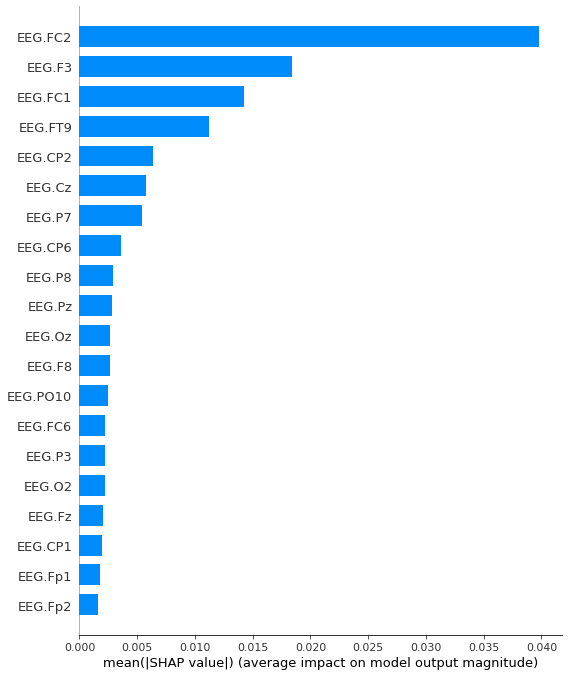

In [20]:
shap.summary_plot(shap_values[0][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

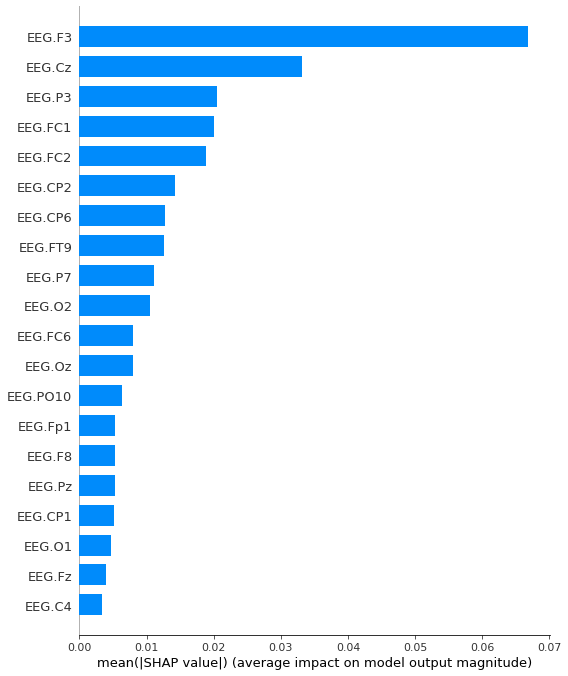

In [21]:
shap.summary_plot(shap_values[1][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

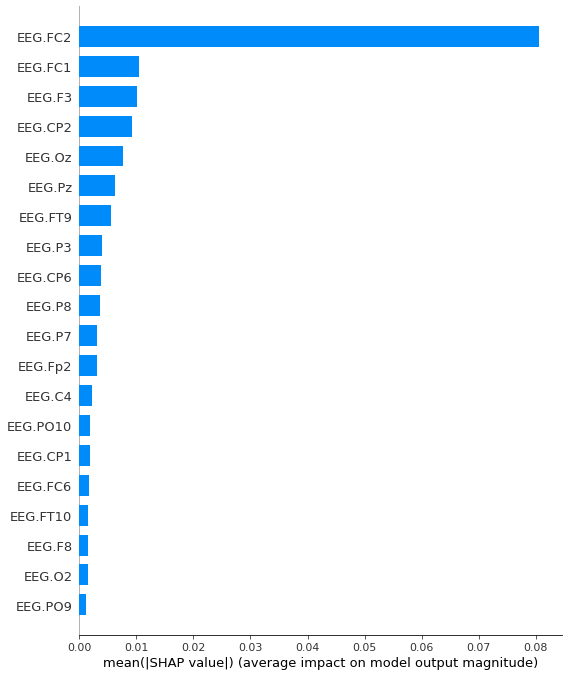

In [22]:
shap.summary_plot(shap_values[2][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

# CYY noise-base model

In [23]:
path_list = ['./{}/base/{}.csv', './{}/noise/{}.csv']

In [24]:
cyy_eeg_input_con, output_con = generation_cnn_con_data(path_list, 'sbs', task, device)

10
20
1back
3back
10
20
1back
3back


In [25]:
print(cyy_eeg_input_con.size())
print(output_con.size())

torch.Size([2048, 32, 120])
torch.Size([2048])


In [26]:
dataset_con = MakeDataset(cyy_eeg_input_con, output_con)
train_dataset_con, test_dataset_con = random_split(dataset_con, [1536,512])
trainloader_con = DataLoader(train_dataset_con, 
                         batch_size=256, 
                         shuffle=True)

testloader_con = DataLoader(test_dataset_con,
                        batch_size = 256,
                        shuffle=True)


In [27]:
model_con = CNNEEG_32(32)
his = train_CNNEEG(model_con, trainloader_con, 1000, 0.0001, device= device)

Epoch 1 / 1000: Loss = 1.134
Epoch 2 / 1000: Loss = 1.121


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 3 / 1000: Loss = 1.107
Epoch 4 / 1000: Loss = 1.094
Epoch 5 / 1000: Loss = 1.083
Epoch 6 / 1000: Loss = 1.073
Epoch 7 / 1000: Loss = 1.065
Epoch 8 / 1000: Loss = 1.058
Epoch 9 / 1000: Loss = 1.052
Epoch 10 / 1000: Loss = 1.047
Epoch 11 / 1000: Loss = 1.042
Epoch 12 / 1000: Loss = 1.038
Epoch 13 / 1000: Loss = 1.034
Epoch 14 / 1000: Loss = 1.031
Epoch 15 / 1000: Loss = 1.028
Epoch 16 / 1000: Loss = 1.025
Epoch 17 / 1000: Loss = 1.022
Epoch 18 / 1000: Loss = 1.020
Epoch 19 / 1000: Loss = 1.018
Epoch 20 / 1000: Loss = 1.016
Epoch 21 / 1000: Loss = 1.014
Epoch 22 / 1000: Loss = 1.013
Epoch 23 / 1000: Loss = 1.012
Epoch 24 / 1000: Loss = 1.010
Epoch 25 / 1000: Loss = 1.008
Epoch 26 / 1000: Loss = 1.007
Epoch 27 / 1000: Loss = 1.006
Epoch 28 / 1000: Loss = 1.004
Epoch 29 / 1000: Loss = 1.003
Epoch 30 / 1000: Loss = 1.002
Epoch 31 / 1000: Loss = 1.001
Epoch 32 / 1000: Loss = 0.999
Epoch 33 / 1000: Loss = 0.998
Epoch 34 / 1000: Loss = 0.997
Epoch 35 / 1000: Loss = 0.995
Epoch 36 / 1000: 

In [28]:
train_pred_list_con, train_target_list_con, test_pred_list_con, test_target_list_con = evaluation_eegcnn(model_con, trainloader_con, testloader_con, 256, device)

Train dataset loss : 0.8308971722920736
Train dataset acc :71.6796875%
Test dataset loss : 1.0236098766326904
Test dataset acc :52.9296875%


In [29]:
import shap

In [30]:
explainer_shap_con = shap.DeepExplainer(model_con, cyy_eeg_input_con.float()[:100])
shap_values_con = explainer_shap_con.shap_values(cyy_eeg_input_con.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [31]:
for i in range(len(shap_values_con)):
    shap_values_con[i] = shap_values_con[i].reshape(100, 120, 32)

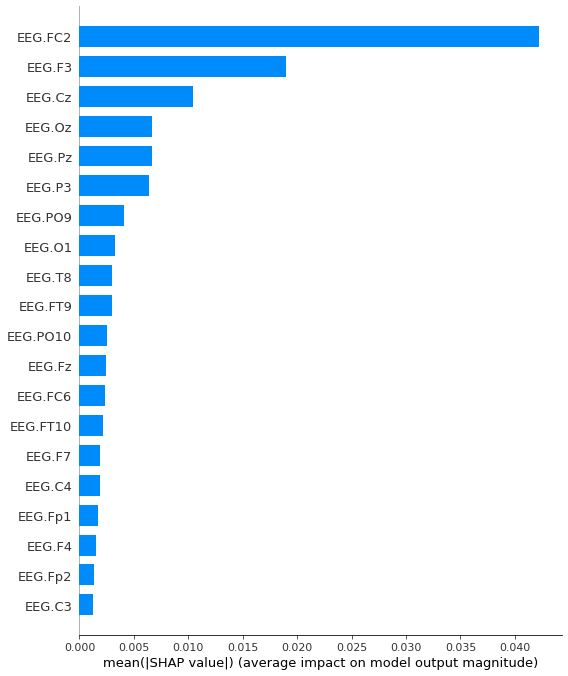

In [32]:
shap.summary_plot(shap_values_con[0][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

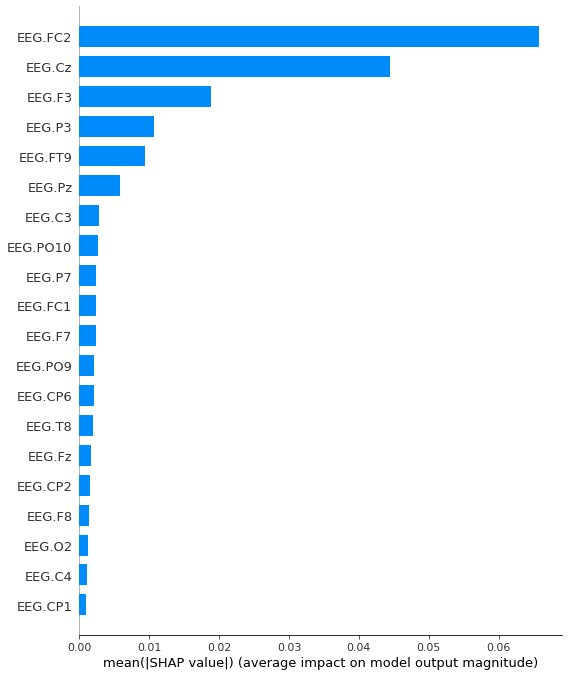

In [33]:
shap.summary_plot(shap_values_con[1][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

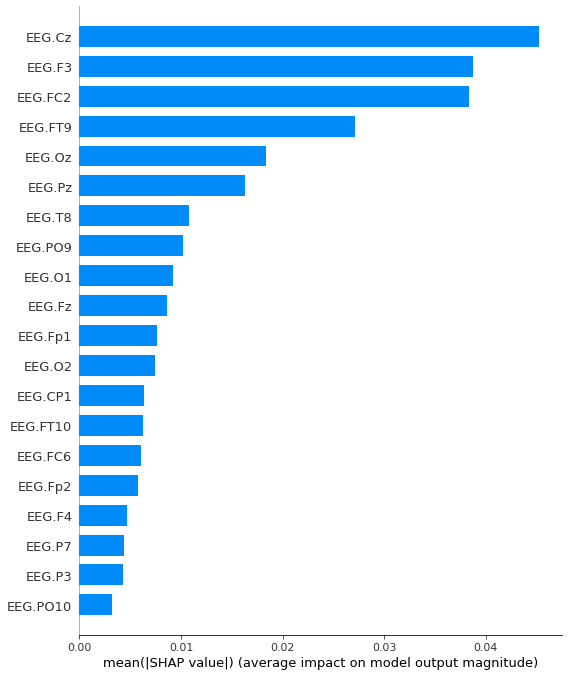

In [34]:
shap.summary_plot(shap_values_con[2][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

# CYY noise CNN

In [35]:
eeg_input_noise, output_noise =  generation_cnn_noisedata('./{}/noise/{}.csv', 'sbs', task, device)

10
20
1back
3back


In [36]:
print(eeg_input_noise.size())
print(output_noise.size())

dataset_noise = MakeDataset(eeg_input_noise, output_noise)
train_dataset_noise, test_dataset_noise = random_split(dataset_noise, [1536,512])
trainloader_noise = DataLoader(train_dataset_noise, 
                         batch_size=256, 
                         shuffle=True)

testloader_noise = DataLoader(test_dataset_noise,
                        batch_size = 256,
                        shuffle=True)


torch.Size([2048, 32, 120])
torch.Size([2048])


In [47]:
model_noise = CNNEEG_32(32)
his = train_CNNEEG(model_noise, trainloader_noise, 3000, 0.001, device= device)

Epoch 1 / 3000: Loss = 1.074
Epoch 2 / 3000: Loss = 1.040
Epoch 3 / 3000: Loss = 1.027
Epoch 4 / 3000: Loss = 1.022
Epoch 5 / 3000: Loss = 1.016
Epoch 6 / 3000: Loss = 1.012
Epoch 7 / 3000: Loss = 1.007
Epoch 8 / 3000: Loss = 1.003
Epoch 9 / 3000: Loss = 0.999
Epoch 10 / 3000: Loss = 0.995
Epoch 11 / 3000: Loss = 0.991
Epoch 12 / 3000: Loss = 0.987
Epoch 13 / 3000: Loss = 0.983
Epoch 14 / 3000: Loss = 0.979
Epoch 15 / 3000: Loss = 0.975
Epoch 16 / 3000: Loss = 0.967
Epoch 17 / 3000: Loss = 0.962
Epoch 18 / 3000: Loss = 0.956
Epoch 19 / 3000: Loss = 0.948
Epoch 20 / 3000: Loss = 0.944
Epoch 21 / 3000: Loss = 0.933
Epoch 22 / 3000: Loss = 0.924
Epoch 23 / 3000: Loss = 0.917
Epoch 24 / 3000: Loss = 0.919
Epoch 25 / 3000: Loss = 0.922
Epoch 26 / 3000: Loss = 0.913
Epoch 27 / 3000: Loss = 0.910
Epoch 28 / 3000: Loss = 0.908
Epoch 29 / 3000: Loss = 0.901
Epoch 30 / 3000: Loss = 0.897
Epoch 31 / 3000: Loss = 0.895
Epoch 32 / 3000: Loss = 0.891
Epoch 33 / 3000: Loss = 0.888
Epoch 34 / 3000: Lo

In [48]:
trainnoise_pred_list, trainnoise_target_list, testnoise_pred_list, testnoise_target_list = evaluation_eegcnn(model_noise,
                                                                                                              trainloader_noise, testloader_noise, 256, device)

Train dataset loss : 0.7182537118593851
Train dataset acc :82.55208730697632%
Test dataset loss : 1.0606032609939575
Test dataset acc :48.046875%


In [39]:
torch.argmax(model_noise(eeg_input_noise[:256].float()), dim = 1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [40]:
explainer_shap_noise = shap.DeepExplainer(model_noise, eeg_input_noise.float()[:100])
shap_values_noise = explainer_shap_noise.shap_values(eeg_input_noise.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [41]:
for i in range(len(shap_values_noise)):
    shap_values_noise[i] = shap_values_noise[i].reshape(100, 120, 32)

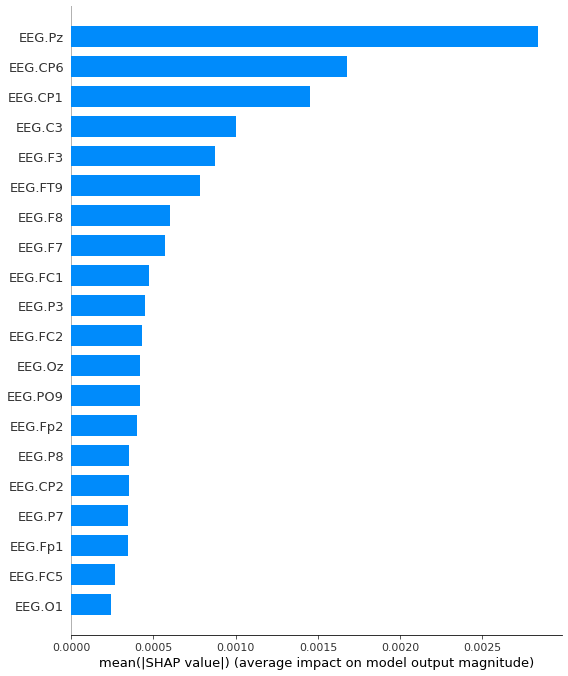

In [42]:
shap.summary_plot(shap_values_noise[0][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

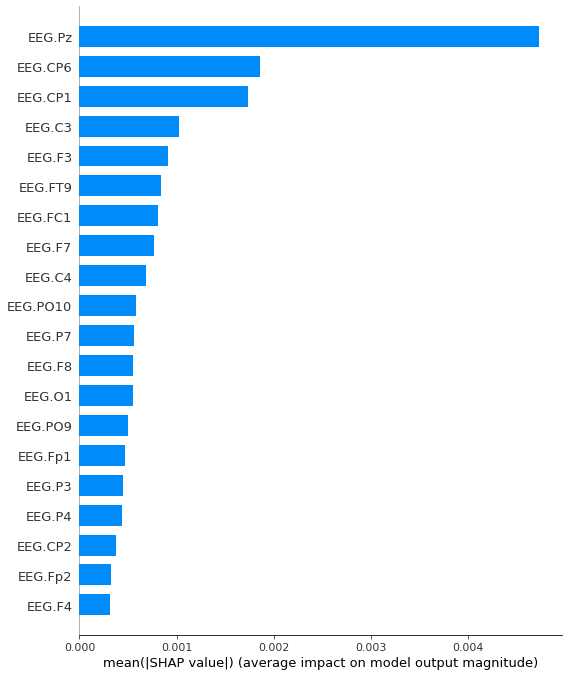

In [43]:
shap.summary_plot(shap_values_noise[1][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

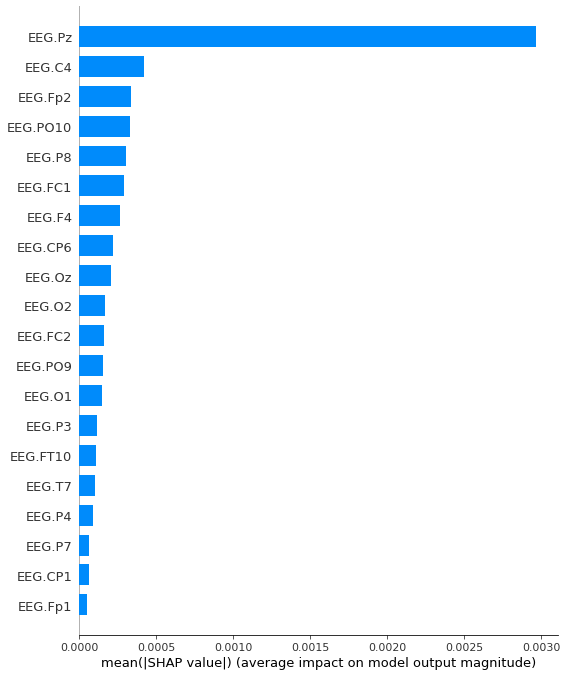

In [44]:
shap.summary_plot(shap_values_noise[2][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')